# Diffusion Models from Scratch: FashionMNIST

## Introduction

Learn to build a **Denoising Diffusion Probabilistic Model (DDPM)** from scratch!

### What are Diffusion Models?
Diffusion models learn to generate images by:
1. **Forward process**: Gradually adding noise to images until they become pure noise
2. **Reverse process**: Learning to remove noise step-by-step to recover/generate images

### Key Concepts
- **Noise schedule**: How much noise to add at each step
- **U-Net**: Neural network that predicts noise to remove
- **Training**: Learn to predict the noise added at each timestep
- **Sampling**: Start from noise and iteratively denoise to generate images

### What You'll Build
- Complete diffusion model from scratch
- Train on FashionMNIST (28x28 grayscale fashion items)
- Generate new fashion items after training

Let's begin! 🚀

## 1. Setup and Imports

In [ ]:
# Install required packages
!pip install -q torch torchvision matplotlib tqdm pillow numpy

print("✓ Packages installed!")

✓ Packages installed!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import math

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda
PyTorch version: 2.8.0+cu128


## 2. Hyperparameters and Configuration

In [ ]:
# Model hyperparameters
image_size = 28  # FashionMNIST native size
channels = 1  # Grayscale
batch_size = 128

# Diffusion hyperparameters
timesteps = 1000  # Number of diffusion steps
beta_start = 0.0001  # Starting noise level
beta_end = 0.02  # Ending noise level

# Training hyperparameters
num_epochs = 20  # Increase for better results (20-50)
learning_rate = 1e-3

print(f"Configuration:")
print(f"  Image size: {image_size}x{image_size}")
print(f"  Diffusion steps: {timesteps}")
print(f"  Training epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")

Configuration:
  Image size: 28x28
  Diffusion steps: 1000
  Training epochs: 20
  Batch size: 128


## 3. Load FashionMNIST Dataset

Dataset loaded: 60000 images
Number of batches: 469


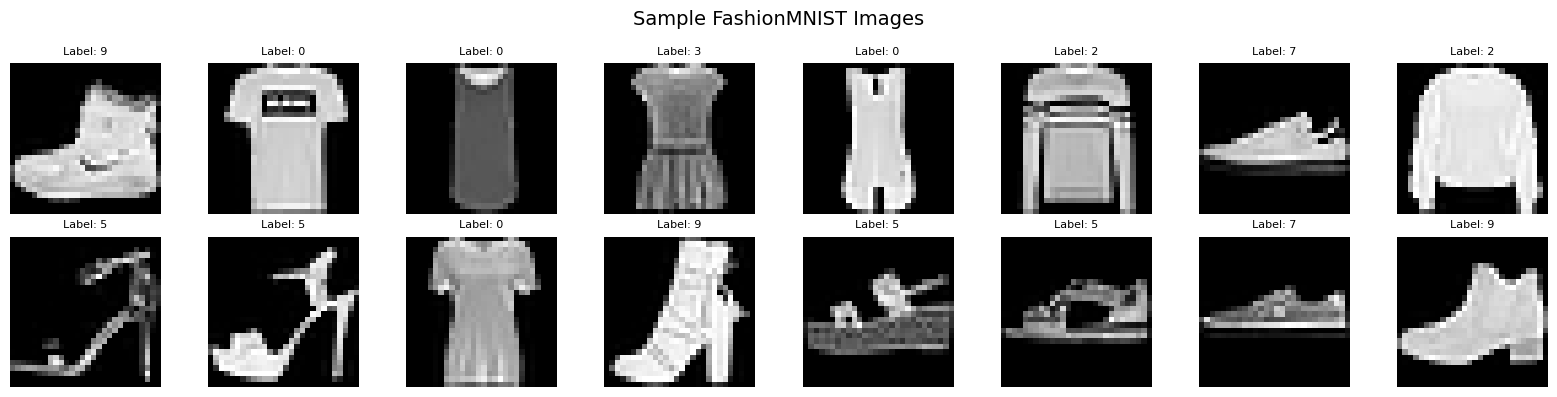


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# Transform: normalize to [-1, 1] (standard for diffusion models)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

# Load dataset
dataset = FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset loaded: {len(dataset)} images")
print(f"Number of batches: {len(dataloader)}")

# Visualize samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    ax = axes[i // 8, i % 8]
    img, label = dataset[i]
    # Denormalize for visualization
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}", fontsize=8)

plt.suptitle("Sample FashionMNIST Images", fontsize=14)
plt.tight_layout()
plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"\nClasses: {class_names}")

## 4. Diffusion Process Theory

### Forward Process (Adding Noise)
At each timestep $t$, we add Gaussian noise according to a schedule:

$$q(x_t | x_{t-1}) = N(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

We can directly sample $x_t$ from $x_0$ using:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$

where $\epsilon \sim N(0, I)$ and $\bar{\alpha}_t = \prod_{i=1}^t (1-\beta_i)$

### Reverse Process (Denoising)
We learn to reverse the process:

$$p_\theta(x_{t-1} | x_t) = N(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

### Training Objective
Learn to predict the noise $\epsilon$ added at each step:

$$L = \mathbb{E}_{t, x_0, \epsilon}[\|\epsilon - \epsilon_\theta(x_t, t)\|^2]$$

![image.png](https://github.com/user-attachments/assets/982c49cb-0583-494f-ab37-2e33cc839cca)

## 5. Noise Schedule

Define the noise schedule and precompute values for efficiency.

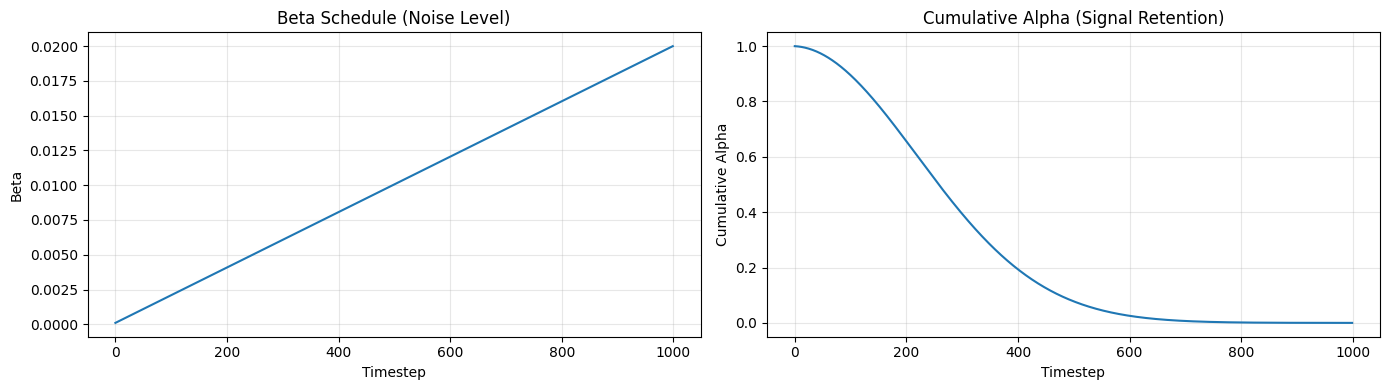

✓ Noise schedule created
  At t=0: beta=0.000100, keep 99.99% of signal
  At t=999: beta=0.020000, keep 0.00% of signal


In [ ]:
def create_noise_schedule(timesteps, beta_start, beta_end):
    """
    Create linear noise schedule.

    Returns:
        Dictionary with precomputed values for efficient sampling
    """
    # Linear schedule from beta_start to beta_end
    betas = torch.linspace(beta_start, beta_end, timesteps)

    # Compute alphas
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Precompute values needed for sampling
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # Posterior variance
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    return {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'alphas_cumprod_prev': alphas_cumprod_prev,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'posterior_variance': posterior_variance,
    }

# Create schedule
noise_schedule = create_noise_schedule(timesteps, beta_start, beta_end)

# Visualize noise schedule
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(noise_schedule['betas'].numpy())
axes[0].set_title('Beta Schedule (Noise Level)', fontsize=12)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Beta')
axes[0].grid(True, alpha=0.3)

axes[1].plot(noise_schedule['alphas_cumprod'].numpy())
axes[1].set_title('Cumulative Alpha (Signal Retention)', fontsize=12)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Cumulative Alpha')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Noise schedule created")
print(f"  At t=0: beta={noise_schedule['betas'][0]:.6f}, keep {noise_schedule['alphas_cumprod'][0]:.2%} of signal")
print(f"  At t={timesteps-1}: beta={noise_schedule['betas'][-1]:.6f}, keep {noise_schedule['alphas_cumprod'][-1]:.2%} of signal")

## 6. Forward Diffusion (Adding Noise)

Function to add noise to images at any timestep.

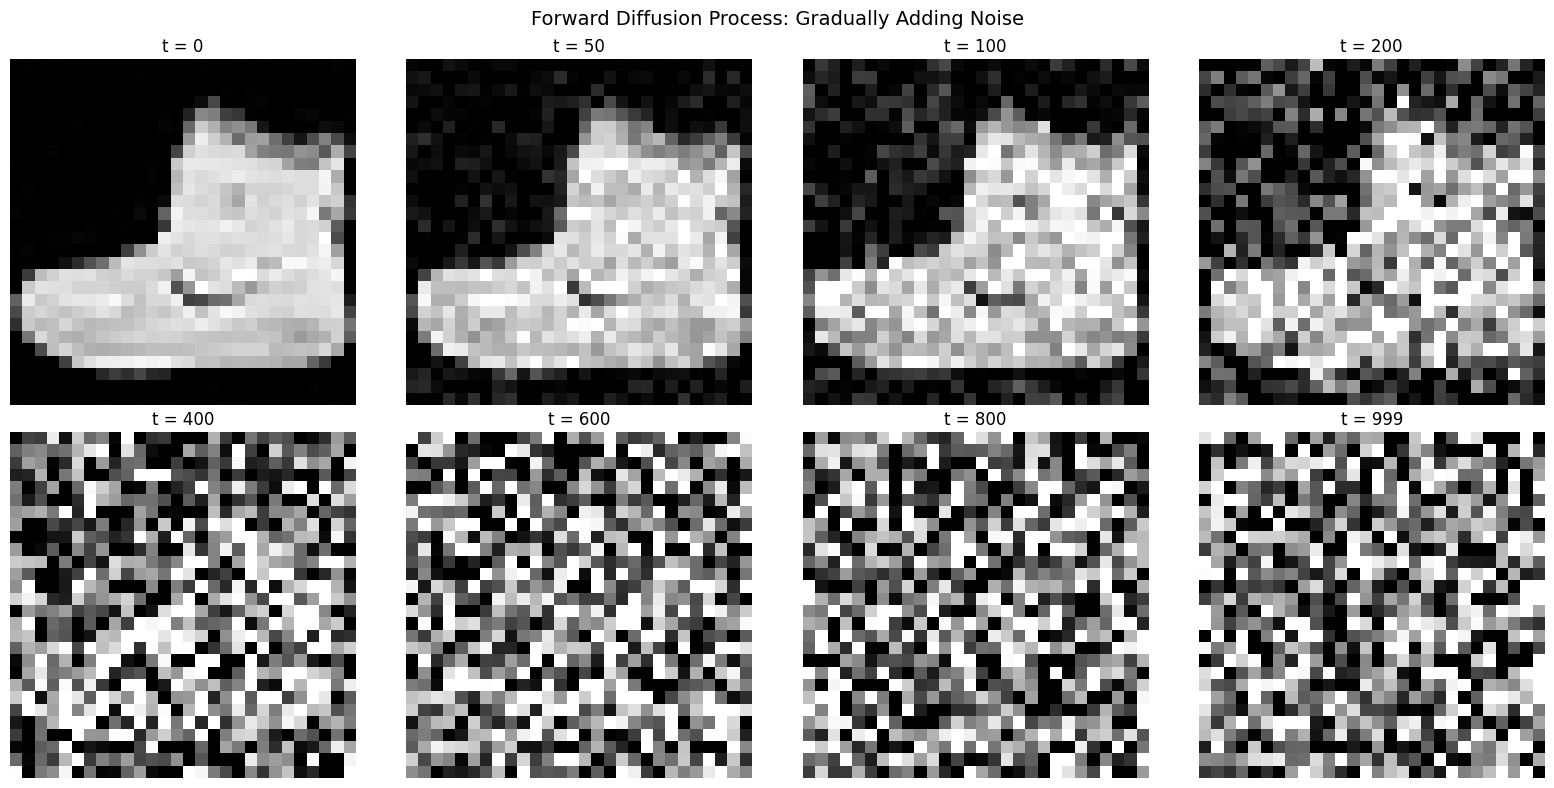

✓ Forward diffusion visualized
  Notice how the image becomes pure noise as t increases


In [ ]:
def forward_diffusion_sample(x_0, t, noise_schedule, device="cpu"):
    """
    Add noise to images at timestep t.

    Args:
        x_0: Original images [batch_size, C, H, W]
        t: Timesteps [batch_size]
        noise_schedule: Precomputed noise schedule

    Returns:
        noisy_images: Noised images
        noise: The noise that was added
    """
    # Sample noise
    noise = torch.randn_like(x_0)

    # Get sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod for timesteps t
    # Convert t to CPU for indexing since noise_schedule is on CPU
    t_cpu = t.cpu()
    sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t_cpu].to(device)
    sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t_cpu].to(device)

    # Reshape for broadcasting
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t[:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t[:, None, None, None]

    # Add noise: x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
    noisy_images = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    return noisy_images, noise

# Visualize forward diffusion process
sample_image, _ = dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

timesteps_to_show = [0, 50, 100, 200, 400, 600, 800, 999]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, t_val in enumerate(timesteps_to_show):
    t = torch.tensor([t_val], device=device)
    noisy_img, _ = forward_diffusion_sample(sample_image, t, noise_schedule, device)

    # Denormalize and convert to numpy
    img_to_show = (noisy_img.cpu().squeeze() + 1) / 2  # [-1, 1] -> [0, 1]
    img_to_show = torch.clamp(img_to_show, 0, 1)

    axes[i].imshow(img_to_show, cmap='gray')
    axes[i].set_title(f"t = {t_val}", fontsize=12)
    axes[i].axis('off')

plt.suptitle("Forward Diffusion Process: Gradually Adding Noise", fontsize=14)
plt.tight_layout()
plt.show()

print("✓ Forward diffusion visualized")
print("  Notice how the image becomes pure noise as t increases")

## 7. U-Net Model Architecture

U-Net with time embeddings to predict noise.

In [ ]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings


class Block(nn.Module):
    """Residual block with time embedding."""
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.bn1 = nn.GroupNorm(8, out_ch)
        self.bn2 = nn.GroupNorm(8, out_ch)

        # Residual connection
        if in_ch != out_ch:
            self.residual_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.bn1(h)
        h = F.relu(h)

        # Add time embedding
        time_emb = self.time_mlp(t)
        h = h + time_emb[:, :, None, None]

        h = self.conv2(h)
        h = self.bn2(h)
        h = F.relu(h)

        # Residual
        return h + self.residual_conv(x)


class SimpleUNet(nn.Module):
    """
    Simplified U-Net for diffusion models on 28x28 images.
    Uses 2 downsampling steps to avoid size mismatch issues.
    """
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_emb_dim)

        # Encoder (downsampling) - only 2 levels for 28x28
        self.enc1 = Block(in_channels, 64, time_emb_dim)    # 28x28
        self.down1 = nn.Conv2d(64, 64, 4, 2, 1)             # -> 14x14

        self.enc2 = Block(64, 128, time_emb_dim)            # 14x14
        self.down2 = nn.Conv2d(128, 128, 4, 2, 1)           # -> 7x7

        # Bottleneck
        self.bottleneck = Block(128, 256, time_emb_dim)     # 7x7

        # Decoder (upsampling)
        self.up2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)    # -> 14x14
        self.dec2 = Block(256, 128, time_emb_dim)           # 128 from up + 128 from enc2

        self.up1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)     # -> 28x28
        self.dec1 = Block(128, 64, time_emb_dim)            # 64 from up + 64 from enc1

        # Output
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)

        # Encoder
        e1 = self.enc1(x, t_emb)                # 28x28 x 64
        x = self.down1(e1)                       # 14x14 x 64

        e2 = self.enc2(x, t_emb)                # 14x14 x 128
        x = self.down2(e2)                       # 7x7 x 128

        # Bottleneck
        x = self.bottleneck(x, t_emb)           # 7x7 x 256

        # Decoder with skip connections
        x = self.up2(x)                          # 14x14 x 128
        x = torch.cat([x, e2], dim=1)           # 14x14 x 256
        x = self.dec2(x, t_emb)                 # 14x14 x 128

        x = self.up1(x)                          # 28x28 x 64
        x = torch.cat([x, e1], dim=1)           # 28x28 x 128
        x = self.dec1(x, t_emb)                 # 28x28 x 64

        return self.out(x)                       # 28x28 x out_channels

# Create model
model = SimpleUNet(in_channels=channels, out_channels=channels).to(device)
print(f"✓ Model created")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
test_input = torch.randn(2, channels, image_size, image_size).to(device)
test_t = torch.randint(0, timesteps, (2,)).to(device)
test_output = model(test_input, test_t)
print(f"  Test input shape: {test_input.shape}")
print(f"  Test output shape: {test_output.shape}")
assert test_output.shape == test_input.shape, "Output shape mismatch!"
print(f"  ✓ Shape test passed!")

✓ Model created
  Parameters: 2,848,833
  Test input shape: torch.Size([2, 1, 28, 28])
  Test output shape: torch.Size([2, 1, 28, 28])
  ✓ Shape test passed!


## 8. Training Loop

Starting training...


Epoch 1/20: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s, loss=0.0540]


Epoch 1/20 - Average Loss: 0.0899


Epoch 2/20: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s, loss=0.0511]


Epoch 2/20 - Average Loss: 0.0528


Epoch 3/20: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s, loss=0.0500]


Epoch 3/20 - Average Loss: 0.0473


Epoch 4/20: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s, loss=0.0375]


Epoch 4/20 - Average Loss: 0.0449


Epoch 5/20: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s, loss=0.0288]


Epoch 5/20 - Average Loss: 0.0436


Epoch 6/20: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s, loss=0.0355]


Epoch 6/20 - Average Loss: 0.0428


Epoch 7/20: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s, loss=0.0570]


Epoch 7/20 - Average Loss: 0.0420


Epoch 8/20: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s, loss=0.0414]


Epoch 8/20 - Average Loss: 0.0412


Epoch 9/20: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s, loss=0.0496]


Epoch 9/20 - Average Loss: 0.0412


Epoch 10/20: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s, loss=0.0447]


Epoch 10/20 - Average Loss: 0.0402


Epoch 11/20: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s, loss=0.0505]


Epoch 11/20 - Average Loss: 0.0404


Epoch 12/20: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s, loss=0.0417]


Epoch 12/20 - Average Loss: 0.0397


Epoch 13/20: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s, loss=0.0522]


Epoch 13/20 - Average Loss: 0.0398


Epoch 14/20: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s, loss=0.0400]


Epoch 14/20 - Average Loss: 0.0394


Epoch 15/20: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s, loss=0.0404]


Epoch 15/20 - Average Loss: 0.0389


Epoch 16/20: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s, loss=0.0399]


Epoch 16/20 - Average Loss: 0.0392


Epoch 17/20: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s, loss=0.0425]


Epoch 17/20 - Average Loss: 0.0393


Epoch 18/20: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s, loss=0.0285]


Epoch 18/20 - Average Loss: 0.0385


Epoch 19/20: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s, loss=0.0413]


Epoch 19/20 - Average Loss: 0.0384


Epoch 20/20: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s, loss=0.0268]


Epoch 20/20 - Average Loss: 0.0389

✓ Training complete!


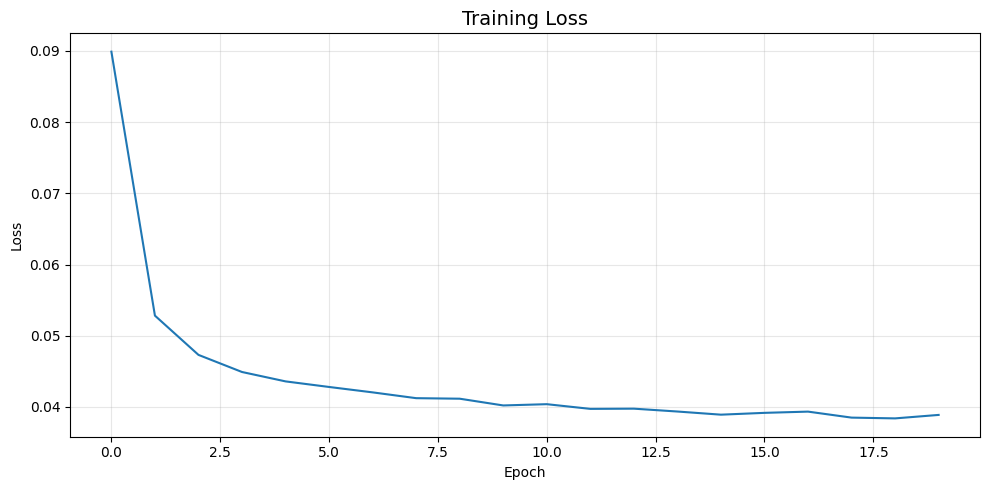

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function (MSE for noise prediction)
criterion = nn.MSELoss()

# Training loop
losses = []

print("Starting training...")
print("=" * 80)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, _) in enumerate(progress_bar):
        images = images.to(device)
        batch_size_current = images.shape[0]

        # Sample random timesteps for each image
        t = torch.randint(0, timesteps, (batch_size_current,), device=device)

        # Forward diffusion: add noise to images
        noisy_images, noise = forward_diffusion_sample(images, t, noise_schedule, device)

        # Predict noise using model
        predicted_noise = model(noisy_images, t)

        # Calculate loss
        loss = criterion(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Record average loss for epoch
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

print("\n" + "=" * 80)
print("✓ Training complete!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Sampling (Generation)

Generate new images by starting from noise and iteratively denoising.

In [ ]:
@torch.no_grad()
def sample(model, noise_schedule, n_samples=16, image_size=28, channels=1, device="cpu"):
    """
    Generate samples using the reverse diffusion process.

    Args:
        model: Trained U-Net model
        noise_schedule: Noise schedule dictionary
        n_samples: Number of samples to generate

    Returns:
        Generated images
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(n_samples, channels, image_size, image_size).to(device)

    timesteps_list = list(range(timesteps))[::-1]  # Reverse order

    for t_idx in tqdm(timesteps_list, desc="Sampling"):
        t = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)

        # Predict noise
        predicted_noise = model(x, t)

        # Get schedule values
        alpha = noise_schedule['alphas'][t_idx].to(device)
        alpha_cumprod = noise_schedule['alphas_cumprod'][t_idx].to(device)
        beta = noise_schedule['betas'][t_idx].to(device)

        if t_idx > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        # Reverse diffusion step
        # x_{t-1} = 1/sqrt(alpha) * (x_t - (1-alpha)/sqrt(1-alpha_cumprod) * noise) + sqrt(beta) * z
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + torch.sqrt(beta) * noise

    model.train()
    return x

print("✓ Sampling function defined")

✓ Sampling function defined


Generating images...


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 125.75it/s]


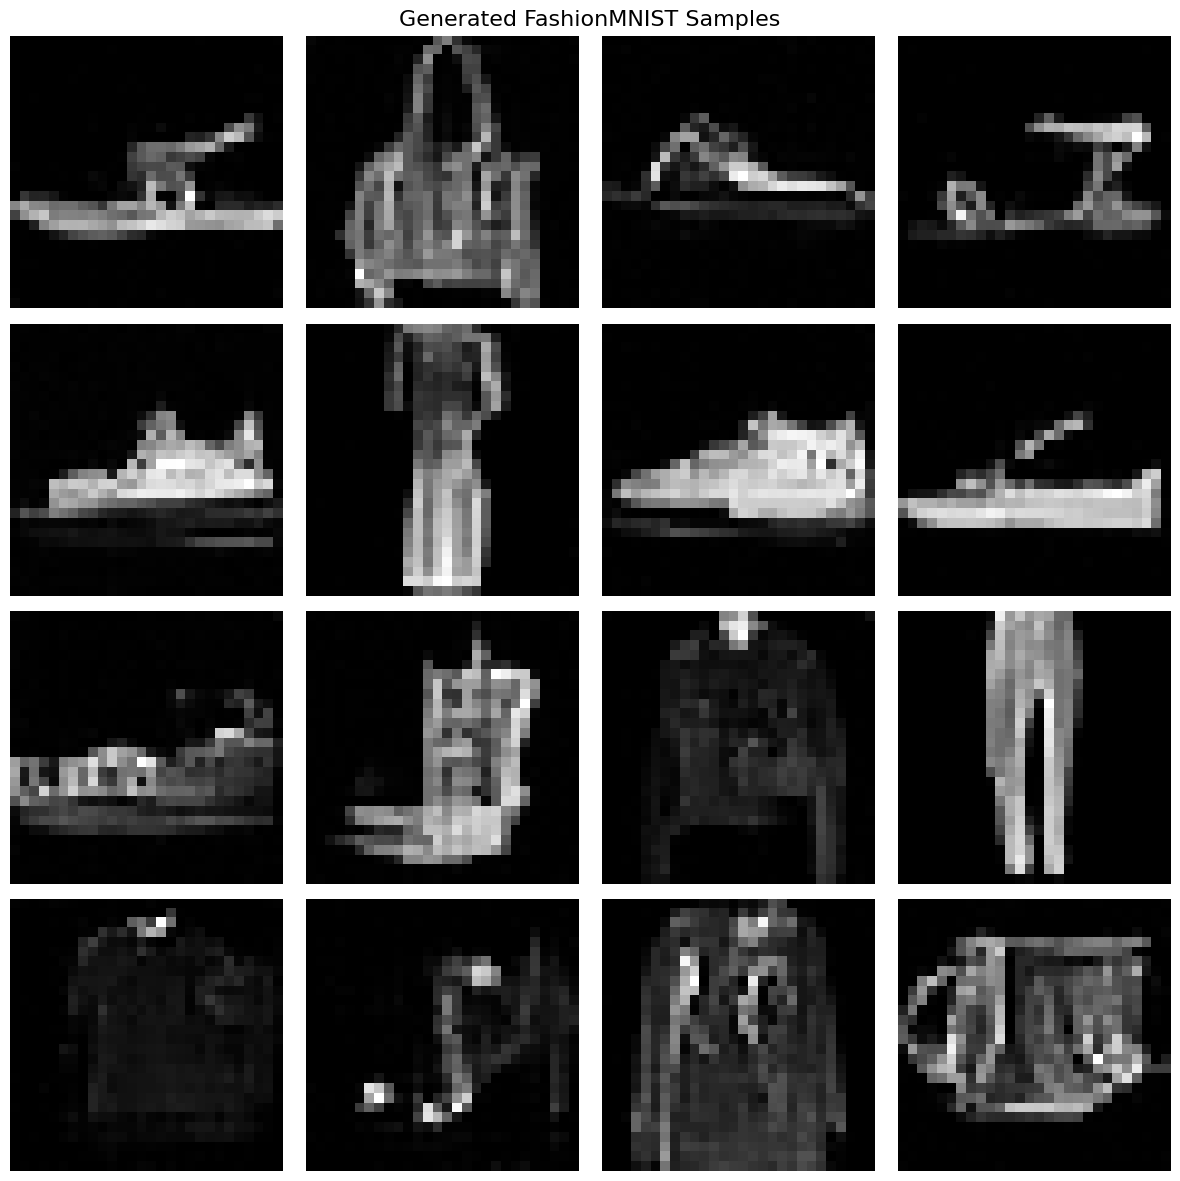

✓ Image generation complete!


In [ ]:
# Generate samples
print("Generating images...")
generated_images = sample(
    model,
    noise_schedule,
    n_samples=16,
    image_size=image_size,
    channels=channels,
    device=device
)

# Denormalize and visualize
generated_images = (generated_images + 1) / 2  # [-1, 1] -> [0, 1]
generated_images = torch.clamp(generated_images, 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')

plt.suptitle("Generated FashionMNIST Samples", fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Image generation complete!")

## 10. Visualize Denoising Process

Generating denoising trajectory...


Sampling with trajectory: 100%|██████████| 1000/1000 [00:07<00:00, 134.18it/s]


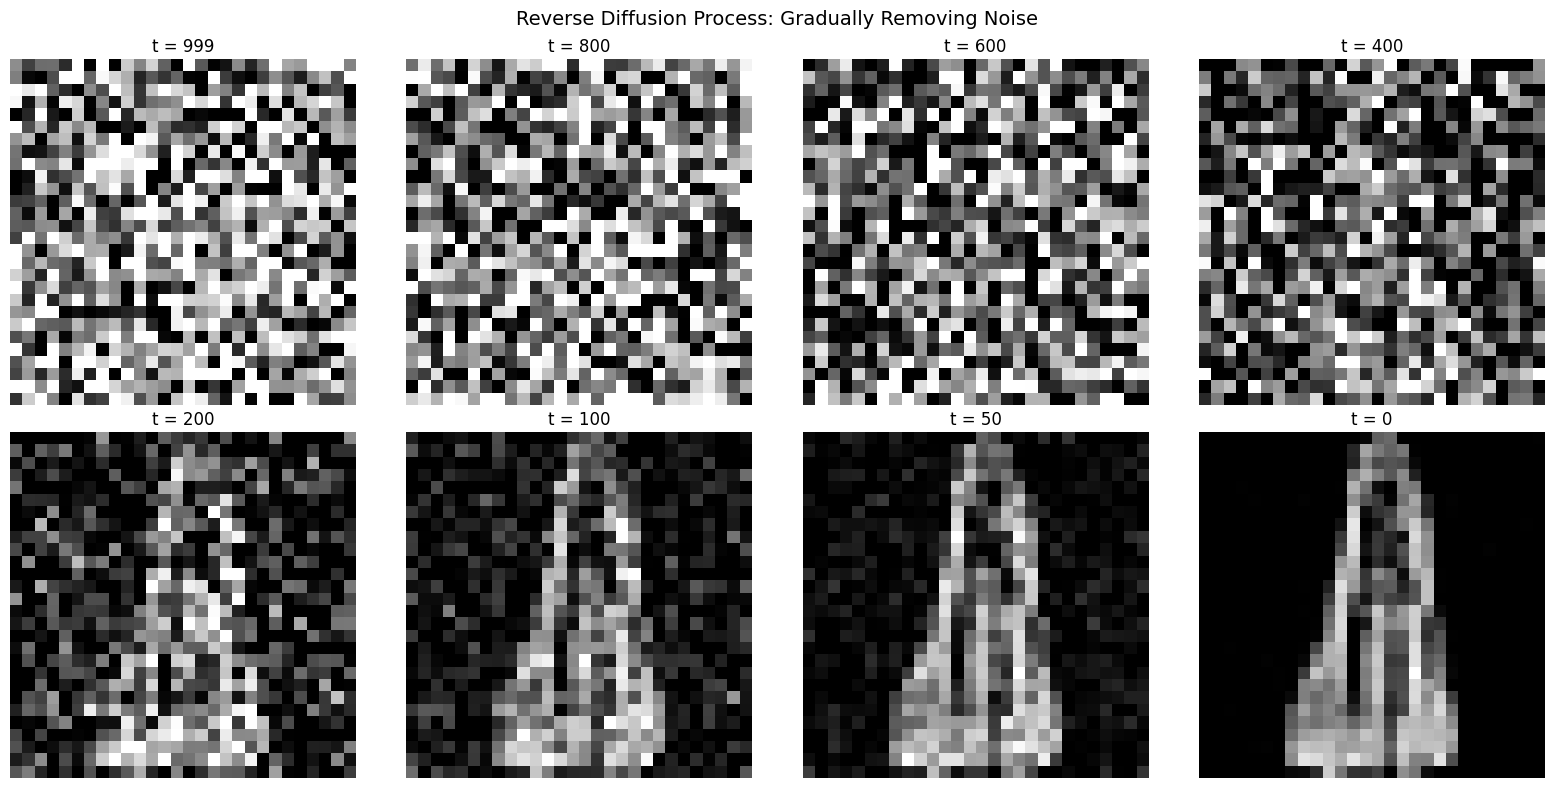

✓ Denoising trajectory visualized


In [ ]:
@torch.no_grad()
def sample_with_trajectory(model, noise_schedule, image_size=28, channels=1, device="cpu"):
    """
    Generate one sample and record the denoising trajectory.
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(1, channels, image_size, image_size).to(device)

    trajectory = []
    timesteps_to_save = [999, 800, 600, 400, 200, 100, 50, 0]

    timesteps_list = list(range(timesteps))[::-1]

    for t_idx in tqdm(timesteps_list, desc="Sampling with trajectory"):
        t = torch.full((1,), t_idx, device=device, dtype=torch.long)

        # Predict noise
        predicted_noise = model(x, t)

        # Get schedule values
        alpha = noise_schedule['alphas'][t_idx].to(device)
        alpha_cumprod = noise_schedule['alphas_cumprod'][t_idx].to(device)
        beta = noise_schedule['betas'][t_idx].to(device)

        if t_idx > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        # Reverse diffusion step
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + torch.sqrt(beta) * noise

        # Save trajectory
        if t_idx in timesteps_to_save:
            trajectory.append((t_idx, x.clone()))

    model.train()
    return trajectory

# Generate trajectory
print("Generating denoising trajectory...")
trajectory = sample_with_trajectory(model, noise_schedule, image_size, channels, device)

# Visualize trajectory
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, (t_val, img) in enumerate(trajectory):
    img_to_show = (img.cpu().squeeze() + 1) / 2  # [-1, 1] -> [0, 1]
    img_to_show = torch.clamp(img_to_show, 0, 1)

    axes[i].imshow(img_to_show, cmap='gray')
    axes[i].set_title(f"t = {t_val}", fontsize=12)
    axes[i].axis('off')

plt.suptitle("Reverse Diffusion Process: Gradually Removing Noise", fontsize=14)
plt.tight_layout()
plt.show()

print("✓ Denoising trajectory visualized")

## 11. Save and Load Model

In [ ]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'noise_schedule': noise_schedule,
    'losses': losses,
}, 'diffusion_fashionmnist.pth')

print("✓ Model saved to 'diffusion_fashionmnist.pth'")

# To load the model:
# checkpoint = torch.load('diffusion_fashionmnist.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# noise_schedule = checkpoint['noise_schedule']
# losses = checkpoint['losses']

## 12. Summary and Next Steps

### What We Built
✅ Complete diffusion model from scratch
✅ Linear noise schedule
✅ U-Net with time embeddings
✅ Training on FashionMNIST
✅ Sampling/generation functionality

### Key Concepts
1. **Forward Process**: Gradually add noise to images
2. **Reverse Process**: Learn to remove noise step-by-step
3. **Noise Schedule**: Control how much noise at each step
4. **U-Net**: Predicts noise to remove
5. **Training**: Minimize difference between predicted and actual noise

### Improvements to Try
1. **Better Noise Schedule**: Cosine schedule instead of linear
2. **More Training**: Train for 50-100 epochs for better quality
3. **Larger Model**: Add more layers or channels
4. **DDIM Sampling**: Faster sampling with fewer steps
5. **Classifier-Free Guidance**: Add conditioning for controlled generation

### Further Reading
- [DDPM Paper](https://arxiv.org/abs/2006.11239)
- [DDIM Paper](https://arxiv.org/abs/2010.02502)
- [Improved DDPM](https://arxiv.org/abs/2102.09672)
- [Hugging Face Diffusion Course](https://github.com/huggingface/diffusion-models-class)

Congratulations! You've built a diffusion model from scratch! 🎉